In [1]:
import os
import pandas as pd
import zipfile
from concurrent.futures import ProcessPoolExecutor
from pandas.api.types import is_datetime64_any_dtype
import numpy as np
from typing import List, Tuple
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
import seaborn as sns

First open time in dataset: 2017-08-17 04:00:00
Last open time in dataset: 2024-08-31 23:59:00
First close time in dataset: 2017-08-17 04:00:59.999000
Last close time in dataset: 2024-08-31 23:59:59.999000
The data does not cover the expected open time range. Check for missing or excess data.
The data does not cover the expected close time range. Check for missing or excess data.
Missing 1-minute intervals found for open_time: 30163
Missing 1-minute intervals found for close_time: 30178


/Users/raghava/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotl

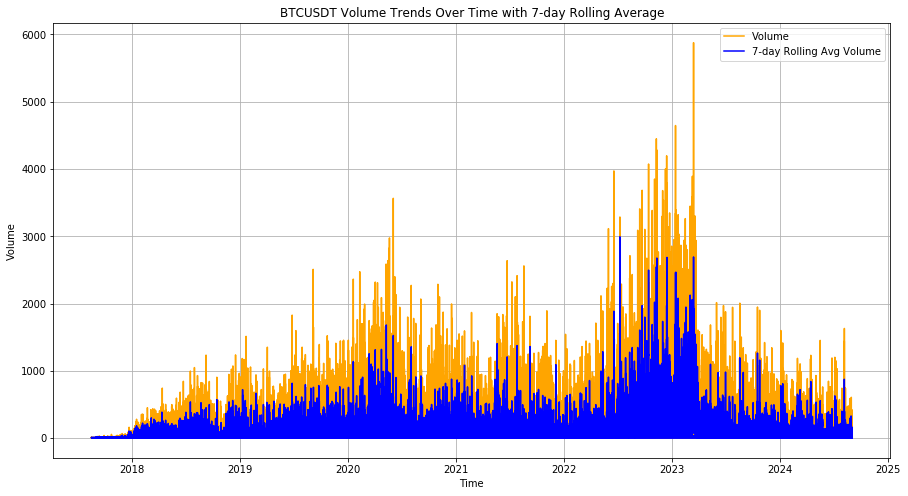

/Users/raghava/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/raghava/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/raghava/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Univariate anamoly of existing feature:0.0


/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


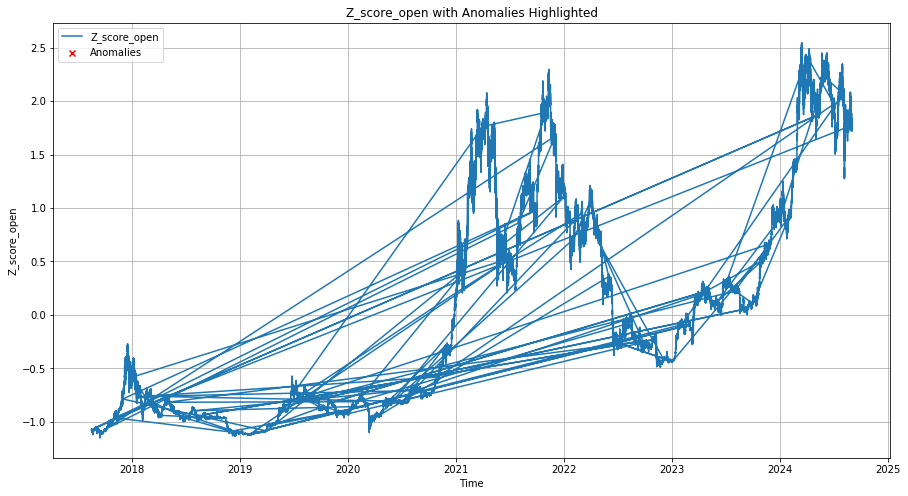

Univariate anamoly of existing feature:0.0


/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


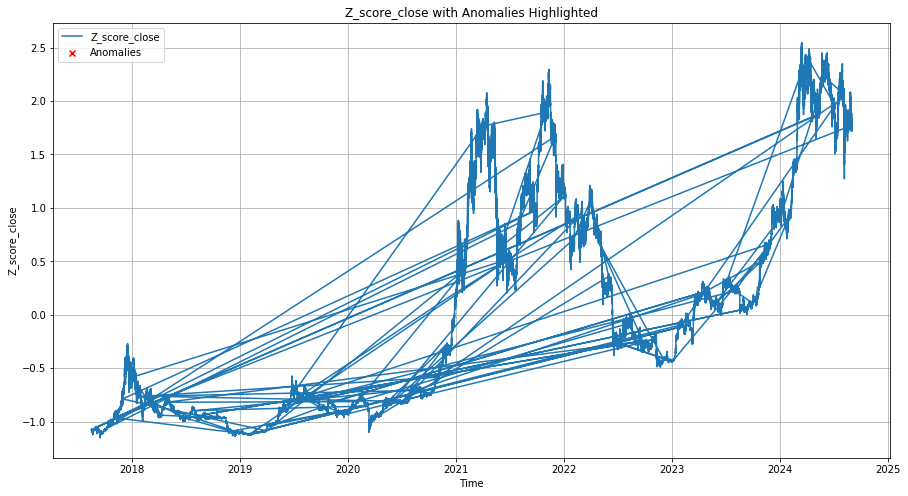

Univariate anamoly of existing feature:0.0


/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


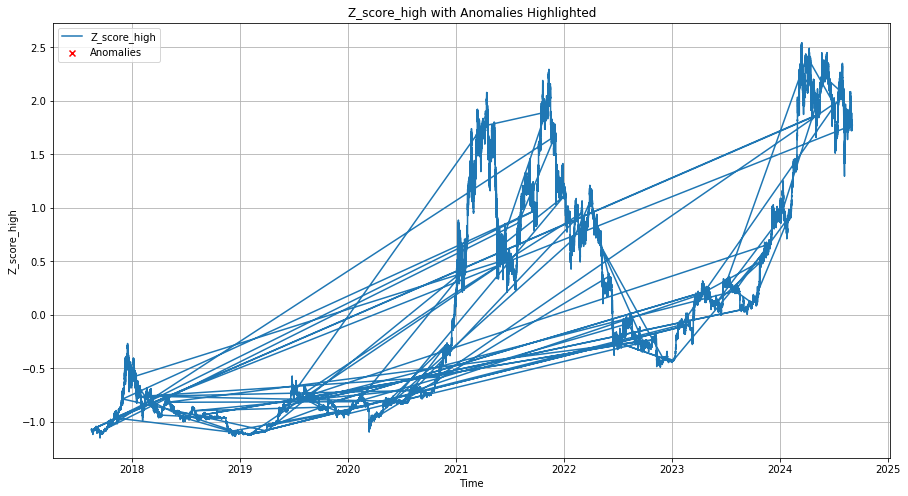

Univariate anamoly of existing feature:0.0


/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


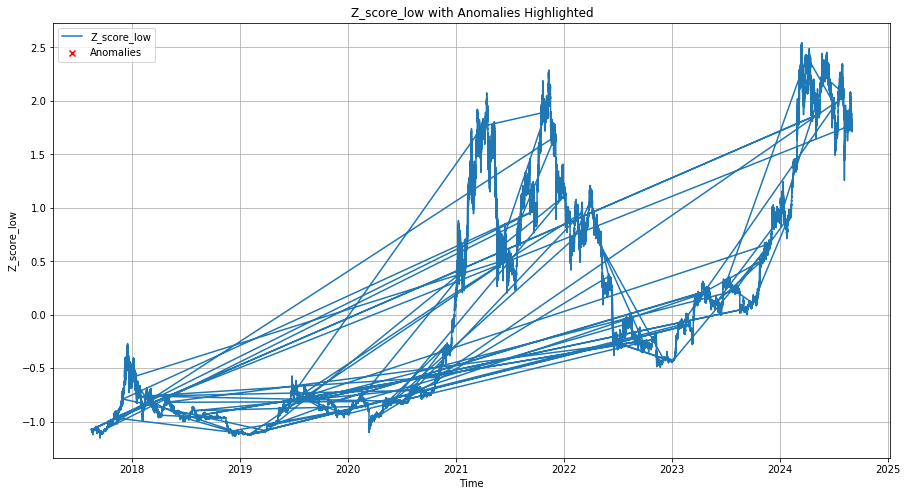

Univariate anamoly of existing feature:1.7384394477629825


/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


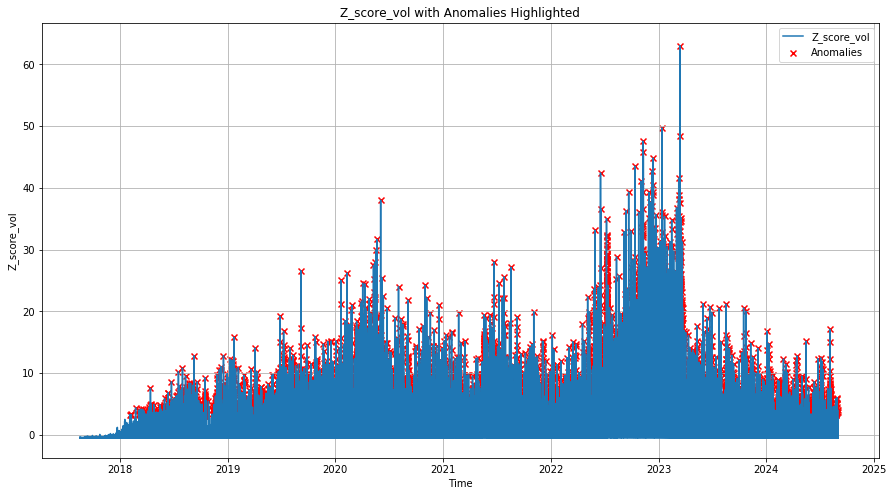

Univariate anamoly of extracted feature:1.5824534900724214


/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


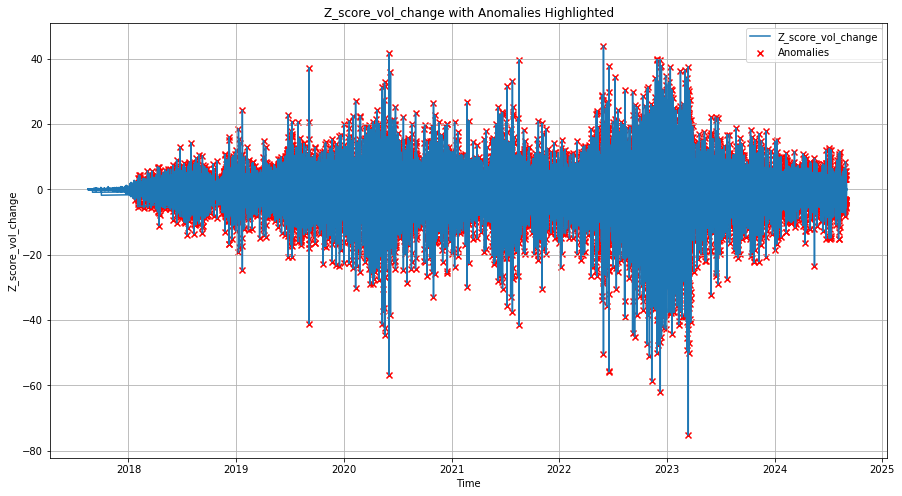

Univariate anamoly of extracted feature:0.12814212066139147


/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


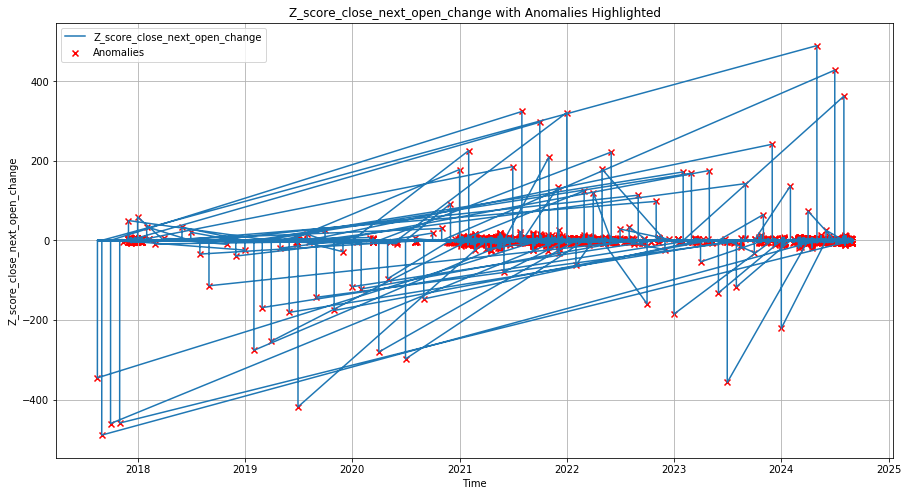

Univariate anamoly of extracted feature:0.12814212066139147


/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


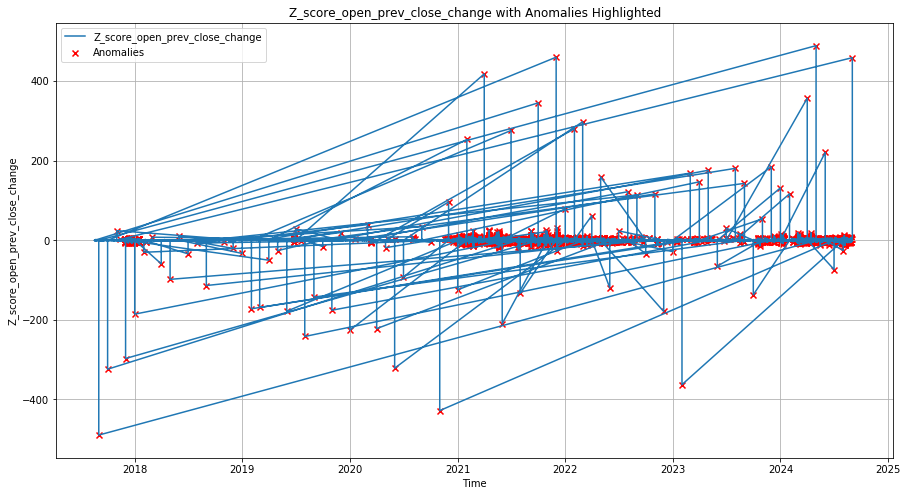

Univariate anamoly of extracted feature:1.9613550630705512


/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


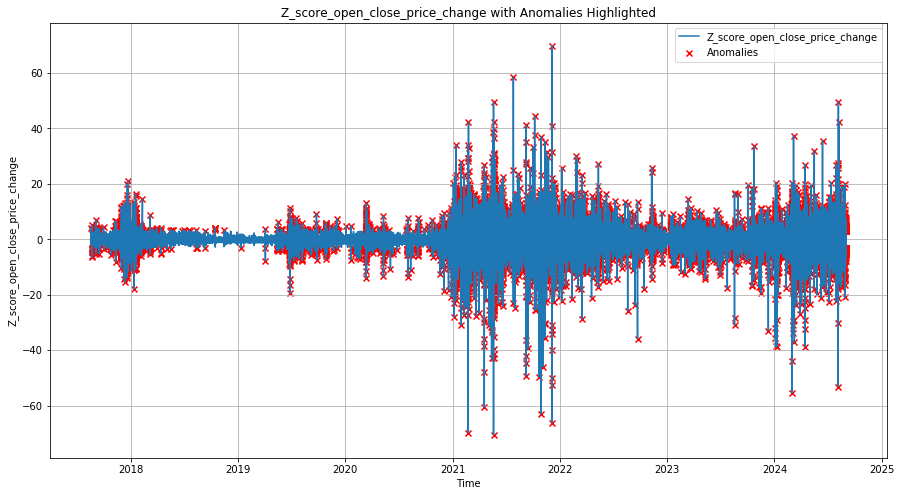

Univariate anamoly of extracted feature:1.7071048236630286


/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/raghava/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


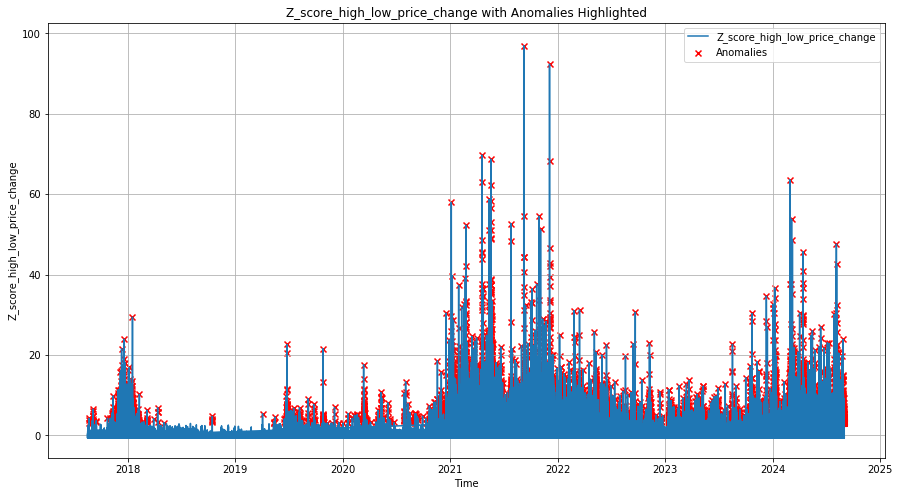

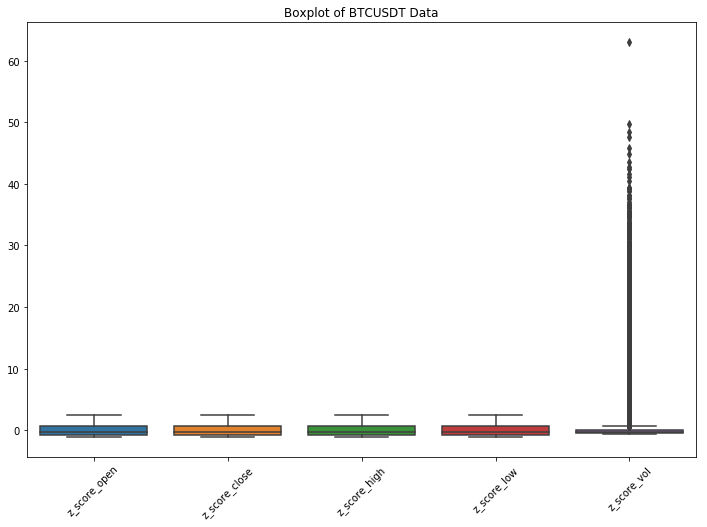

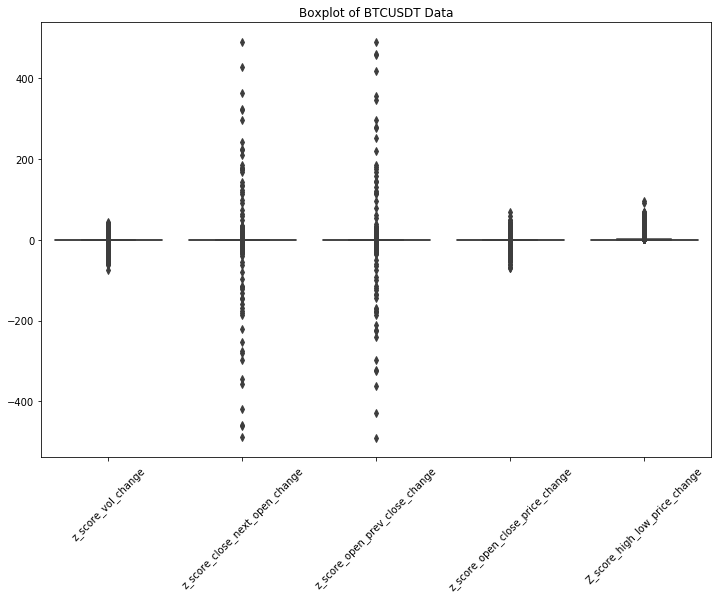

In [ ]:
# Define the path where the zipped BTCUSDT data files are stored
folder_path = "./BTCUSDT"

# List all files in the specified folder and filter only the files
file_list = os.listdir(folder_path)
file_list = [os.path.join(folder_path, f) for f in file_list if os.path.isfile(os.path.join(folder_path, f))]

# Define column names and data types for reading CSV files
column_names = [
    'open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
    'base_asset_volume', 'number_of_trades', 'taker_buy_volume', 
    'taker_buy_base_asset_volume', 'ignore'
]


# Define the expected data types for each column
column_dtypes = {
    'open_time': 'int64',
    'open': 'float64',
    'high': 'float64',
    'low': 'float64',
    'close': 'float64',
    'volume': 'float64',
    'close_time': 'int64',
    'base_asset_volume': 'float64',
    'number_of_trades': 'int64',
    'taker_buy_volume': 'float64',
    'taker_buy_base_asset_volume': 'float64',
    'ignore': 'float64'
}

# Function to check for duplicates in specific columns of a DataFrame
def dup_check(pdf: pd.DataFrame, dims: List[str]) -> None:
    pdf_check = pdf[dims].drop_duplicates()
    cond = len(pdf_check) == len(pdf)
    msg = f"Dups found in: {dims}"
    assert cond, msg

# Function to validate if columns are of timestamp type and contain no null values
def check_timetype(pdf: pd.DataFrame, dims: List[str]) -> None:
    msg = f'One or more columns are not of timestamp type'
    assert all(is_datetime64_any_dtype(pdf[c]) for c in dims), msg
    
    msg = f'One or more columns contain NaT values'
    assert all(pdf[c].notna().all() for c in dims), msg
       
# Function to process a zip file in chunks and concatenate into a DataFrame
def process_zip_with_chunks(zip_path:str, chunksize=50000)->pd.DataFrame:
    pdfs = []
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.endswith('.csv'):
                with zip_ref.open(file_name) as file:
                    chunk_iter = pd.read_csv(file, chunksize=chunksize,names=column_names, dtype=column_dtypes, header=None)
                    for chunk in chunk_iter:
                        pdfs.append(chunk)
                        
    return pd.concat(pdfs, ignore_index=True)

# Function to process all zip files using parallel processing
def process_all_zips(file_list:List[str])->pd.DataFrame:
    final_pdfs = []
    
    with ProcessPoolExecutor() as executor:
        results = executor.map(process_zip_with_chunks, file_list)
        
        for pdf in results:
            final_pdfs.append(pdf)
    
    final_pdf = pd.concat(final_pdfs, ignore_index=True)
    return final_pdf

# Function to check for time completeness and identify any missing time intervals
def check_time_completeness(final_clean_pdf: pd.DataFrame) -> Tuple[List[str], List[str]]:    
    # Calculate the min and max time for open_time and close_time
    first_open_time = final_clean_pdf['open_time'].min()
    last_open_time = final_clean_pdf['open_time'].max()
    first_close_time = final_clean_pdf['close_time'].min()
    last_close_time = final_clean_pdf['close_time'].max()

    print(f"First open time in dataset: {first_open_time}")
    print(f"Last open time in dataset: {last_open_time}")
    print(f"First close time in dataset: {first_close_time}")
    print(f"Last close time in dataset: {last_close_time}")

    # Define the expected time range
    expected_start = pd.Timestamp("2017-08-01 04:00:00")
    expected_end = pd.Timestamp("2024-06-30 23:59:00")
    
    expected_close_start = pd.Timestamp("2017-08-01 04:00:59.999")
    expected_close_end = pd.Timestamp("2024-06-30 23:59:59.999")
    
    # Check if the time range matches the expected range
    if first_open_time >= expected_start and last_open_time <= expected_end:
        print("The data covers the expected time range.")
    else:
        print("The data does not cover the expected open time range. Check for missing or excess data.")
        
    if first_close_time >= expected_close_start and last_close_time <= expected_close_end:
        print("The data covers the expected time range.")
    else:
        print("The data does not cover the expected close time range. Check for missing or excess data.")

    # Generate the full date range with 1-minute intervals
    full_open_time_range = pd.date_range(start=first_open_time, end=last_open_time, freq='1T')
    full_close_time_range = pd.date_range(start=first_close_time, end=last_close_time, freq='1T')

    # Extract actual open_time and close_time values from the dataset
    actual_open_times = final_clean_pdf['open_time']
    actual_close_times = final_clean_pdf['close_time']

    # Compare the two time ranges to find missing timestamps
    missing_open_times = full_open_time_range.difference(actual_open_times)
    missing_close_times = full_close_time_range.difference(actual_close_times)
    
    # Output the results    
    if len(missing_open_times) == 0:
        print("No missing 1-minute intervals in the dataset for open_time.")
    else:
        print(f"Missing 1-minute intervals found for open_time: {len(missing_open_times)}")
        missing_open_times_list=missing_open_times.strftime("%Y-%m-%d %H:%M:%S").tolist()
        
    if len(missing_close_times) == 0:
        print("No missing 1-minute intervals in the dataset for close_time.")
    else:
        print(f"Missing 1-minute intervals found for close_time: {len(missing_close_times)}")
        missing_close_times_list=missing_close_times.strftime("%Y-%m-%d %H:%M:%S").tolist()
    
    return missing_open_times_list, missing_close_times_list

# Function to identify and capture rejected records based on data quality checks
def capture_rejected_records(final_clean_pdf: pd.DataFrame) -> pd.DataFrame:
    # Filter records where 'high' value is greater than 'low' value
    non_rejected_record = final_clean_pdf[final_clean_pdf['high'] > final_clean_pdf['low']]
    rejected_record = final_clean_pdf[final_clean_pdf['high'] < final_clean_pdf['low']]
    
    # Ensure that no incorrect records are present
    cond = len(rejected_record) == 0
    msg = f"High value is greater than low which is not correct"
    assert cond, msg

    # Columns to check for null values
    columns_to_check = ['open_time', 'open', 'high', 'low', 'close', 'volume', 
                        'close_time', 'base_asset_volume', 'number_of_trades', 
                        'taker_buy_volume', 'taker_buy_base_asset_volume']

    # Identify records with null values
    mask = non_rejected_record[columns_to_check].isnull().any(axis=1)
    records_with_nulls = non_rejected_record[mask]
    
    # Create a DataFrame of rejected records
    rejected_pdf = pd.concat([rejected_record, records_with_nulls], ignore_index=True)

    mask = non_rejected_record[columns_to_check].notnull().any(axis=1)

    # Capture the rows with non null values
    non_rejected_pdf = non_rejected_record[mask]

    cond = len(rejected_record) == 0
    msg = f"High value is greater than low which is not correct"
    assert cond, msg
    
    return non_rejected_record, rejected_pdf
        
# Function to plot volume trends with a 7-day rolling average
def plot_volume_trends(non_rejected_record:pd.DataFrame):
    
    %matplotlib inline
    
    # Calculate the 7-day rolling average of volume
    non_rejected_record['volume_rolling_7d'] = non_rejected_record['volume'].rolling(window=7).mean()

    # Plot volume and its rolling average over time
    plt.figure(figsize=(15, 8))
    plt.plot(non_rejected_record['open_time'], non_rejected_record['volume'], label='Volume', color='orange')
    plt.plot(non_rejected_record['open_time'], non_rejected_record['volume_rolling_7d'], label='7-day Rolling Avg Volume', color='blue')

    plt.title('BTCUSDT Volume Trends Over Time with 7-day Rolling Average')
    plt.xlabel('Time')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.show()
        

# Function to extract additional features for further analysis
def feature_extract(non_rejected_pdf: pd.DataFrame) -> pd.DataFrame:
    
    # Calculate price and volume changes
    non_rejected_pdf['open_close_price_change'] = non_rejected_pdf['close'] - non_rejected_pdf['open']
    non_rejected_pdf['high_low_price_change'] = non_rejected_pdf['high'] - non_rejected_pdf['low']
    non_rejected_pdf['open_prev_close_change'] = (non_rejected_pdf['open'] - non_rejected_pdf['close'].shift(-1))
    non_rejected_pdf['close_next_open_change'] = (non_rejected_pdf['close'] - non_rejected_pdf['open'].shift(1))
    non_rejected_pdf['vol_change'] = (non_rejected_pdf['volume'] - non_rejected_pdf['volume'].shift(-1))
    
    # Replacing null caused by shift operation with 0
    non_rejected_pdf['open_prev_close_change']=non_rejected_pdf['open_prev_close_change'].fillna(0)
    non_rejected_pdf['close_next_open_change']=non_rejected_pdf['close_next_open_change'].fillna(0)
    non_rejected_pdf['vol_change']=non_rejected_pdf['vol_change'].fillna(0)

    return non_rejected_pdf

# Normalize the data based on Z-score calculation for existing and extracted features.
def normalize_feature(non_rejected_pdf: pd.DataFrame) -> pd.DataFrame:

    # Calculate Z-scores for existing features (open, close, high, low, and volume)
    non_rejected_pdf["z_score_open"] = (non_rejected_pdf['open'] - non_rejected_pdf['open'].mean())/(non_rejected_pdf['open'].std())
    non_rejected_pdf["z_score_close"] = (non_rejected_pdf['close'] - non_rejected_pdf['close'].mean())/(non_rejected_pdf['close'].std())
    non_rejected_pdf["z_score_high"] = (non_rejected_pdf['high'] - non_rejected_pdf['high'].mean())/(non_rejected_pdf['high'].std())
    non_rejected_pdf["z_score_low"] = (non_rejected_pdf['low'] - non_rejected_pdf['low'].mean())/(non_rejected_pdf['low'].std())
    non_rejected_pdf["z_score_vol"] = (non_rejected_pdf['volume'] - non_rejected_pdf['volume'].mean())/(non_rejected_pdf['volume'].std())

    # Calculate Z-scores for extracted features (volume change and price changes)
    non_rejected_pdf["z_score_vol_change"] = (non_rejected_pdf['vol_change'] - non_rejected_pdf['vol_change'].mean())/(non_rejected_pdf['vol_change'].std())
    non_rejected_pdf["z_score_close_next_open_change"] = (non_rejected_pdf['close_next_open_change'] - non_rejected_pdf['close_next_open_change'].mean())/(non_rejected_pdf['close_next_open_change'].std())
    non_rejected_pdf["z_score_open_prev_close_change"] = (non_rejected_pdf['open_prev_close_change'] - non_rejected_pdf['open_prev_close_change'].mean())/(non_rejected_pdf['open_prev_close_change'].std())
    non_rejected_pdf["z_score_open_close_price_change"] = (non_rejected_pdf['open_close_price_change'] - non_rejected_pdf['open_close_price_change'].mean())/(non_rejected_pdf['open_close_price_change'].std())
    non_rejected_pdf["Z_score_high_low_price_change"] = (non_rejected_pdf['high_low_price_change'] - non_rejected_pdf['high_low_price_change'].mean())/(non_rejected_pdf['high_low_price_change'].std())

    # Return the DataFrame with normalized features
    return non_rejected_pdf

# Function to plot Z-score distribution of volume to identify outlier
def capture_univariate_anamolies(non_rejected_pdf: pd.DataFrame) -> None:
    # Define the columns for existing feature Z-scores
    existing_feature_cols = ["z_score_open","z_score_close","z_score_high","z_score_low","z_score_vol"]
    
    # Loop through existing feature Z-scores and identify anomalies
    for col in existing_feature_cols:
        # Filter rows where the Z-score indicates an outlier (>3 or <-3)
        existing_feature_anomolies= non_rejected_pdf[(non_rejected_pdf[col] > 3) | (non_rejected_pdf[col] < -3)]
        # Calculate and print the percentage of anomalies for the current feature
        print(f"Univariate anamoly of existing feature:{len(existing_feature_anomolies)/len(non_rejected_pdf) * 100}")
        # Plot the Z-score anomalies for the current feature
        plot_z_score_anomalies(non_rejected_pdf, col)

    # Define the columns for extracted feature Z-scores
    extracted_feature_cols = ["z_score_vol_change","z_score_close_next_open_change","z_score_open_prev_close_change","z_score_open_close_price_change","Z_score_high_low_price_change"]
    
    # Loop through existing feature Z-scores and identify anomalies
    for col in extracted_feature_cols:
        # Filter rows where the Z-score indicates an outlier (>3 or <-3)
        extracted_feature_anomolies= non_rejected_pdf[(non_rejected_pdf[col] > 3) | (non_rejected_pdf[col] < -3)]
        # Calculate and print the percentage of anomalies for the current feature
        print(f"Univariate anamoly of extracted feature:{len(extracted_feature_anomolies)/len(non_rejected_pdf) * 100}")
        # Plot the Z-score anomalies for the current feature
        plot_z_score_anomalies(non_rejected_pdf, col)
        
    # Generate boxplots for visual comparison of Z-scores in existing and extracted features
    gen_box_plot(non_rejected_pdf, existing_feature_cols)
    gen_box_plot(non_rejected_pdf, extracted_feature_cols)
    
# Function to generate boxplots for multiple features in a DataFrame
def gen_box_plot(non_rejected_pdf: pd.DataFrame, cols:List[str])->None:
    
    %matplotlib inline
    # Create a figure for the boxplot with specified size
    plt.figure(figsize=(12, 8))
    # Generate a boxplot for the selected columns
    sns.boxplot(data=non_rejected_pdf[cols])
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    plt.title("Boxplot of BTCUSDT Data")
    # Display the plot
    plt.show()
    
#Plots the Z-score of a specified feature and highlights data points that are classified as anomalies (Z-score > 3 or < -3).
def plot_z_score_anomalies(non_rejected_pdf: pd.DataFrame, feature:str)->None:
    
    %matplotlib inline
    
    # Identify anomalies where Z-score is greater than 3 or less than -3
    anomalies = non_rejected_pdf[(non_rejected_pdf[f'{feature}'] > 3) | (non_rejected_pdf[f'{feature}'] < -3)]

    plt.figure(figsize=(15, 8))
    
    # Plot the Z-score values over time
    plt.plot(non_rejected_pdf['open_time'], non_rejected_pdf[feature], label=f'{feature.capitalize()}')
    
    # Highlight anomalies with red 'x' markers
    plt.scatter(anomalies['open_time'], anomalies[feature], color='red', label='Anomalies', marker='x')

    # Add title and labels to the plot
    plt.title(f'{feature.capitalize()} with Anomalies Highlighted')
    plt.xlabel('Time')
    plt.ylabel(feature.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()
    
#Calculates the Mahalanobis distance for each observation in the dataset to identify multivariate anomalies based on the distance from the mean considering the covariance of the data.
def multivariate_anamoly_mahalanobis(selected_data)->pd.DataFrame:

    # Calculate the mean vector and covariance matrix of the data
    mean_vector = selected_data.mean(axis=0)
    cov_matrix = np.cov(selected_data.T)

    # Invert the covariance matrix
    cov_matrix_inv = np.linalg.inv(cov_matrix)

    # Calculate Mahalanobis distance for each row
    mahalanobis_distances = selected_data.apply(lambda row: mahalanobis(row, mean_vector, cov_matrix_inv), axis=1)

    # Set a threshold for identifying outliers (95th percentile of the distances)
    threshold = np.percentile(mahalanobis_distances, 95)

    # Flag outliers based on the threshold
    outliers_mahalanobis = selected_data[mahalanobis_distances > threshold]

    # Display the outliers
    print(f"Multivariate anamoly calculated using Mahalanobis for {selected_data.columns} feature:{len(outliers_mahalanobis)/len(selected_data) * 100}")
    
    return outliers_mahalanobis



# Read the data        
final_pdf = process_all_zips(file_list)

# data validations
# converting time in int64 to datetime64 and validating it
final_pdf['open_time'] = pd.to_datetime(final_pdf['open_time'], unit='ms')
final_pdf['close_time'] = pd.to_datetime(final_pdf['close_time'], unit='ms')

# default value to close time if its null
null_closetime = final_pdf[final_pdf['close_time'].isna()]
non_null_closetime = final_pdf[final_pdf['close_time'].notna()]
null_closetime['close_time'] = null_closetime['open_time'] + pd.Timedelta(seconds=59.999)
final_clean_pdf = pd.concat([null_closetime, non_null_closetime], ignore_index=True)

check_timetype(final_clean_pdf,['open_time','close_time'])

## Data Quality Check
# check dups in close and open time
dup_check(final_clean_pdf, ['open_time'])
dup_check(final_clean_pdf, ['close_time'])

# checking if both close and open time as bitcoin exchange opens for 24/7 including weekend
missing_open_times_list, missing_close_times_list = check_time_completeness(final_clean_pdf)

# Remove wrong records with anamolies 
non_rejected_pdf, rejected_pdf = capture_rejected_records(final_clean_pdf) 

# volume trend analysis
plot_volume_trends(non_rejected_pdf)

# extracting new features based on existing feature
non_rejected_pdf=feature_extract(non_rejected_pdf)

# calculate z_score for both existing and extracted feature
non_rejected_pdf = normalize_feature(non_rejected_pdf)

# univariate anamoly detection using box plot and z-score
capture_univariate_anamolies(non_rejected_pdf)

#multivariate anamoly detection using Mahalanobis distance
#value change of existing feature
existing_feature_cols = ["z_score_open","z_score_close","z_score_high","z_score_low","z_score_vol"]
non_rejected_pdf_existing=non_rejected_pdf[existing_feature_cols]
existing_feature_outlier=multivariate_anamoly_mahalanobis(selected_data=non_rejected_pdf_existing)

#value change of extracted feature
non_rejected_pdf_extracted_value=non_rejected_pdf[['z_score_vol_change','z_score_close_next_open_change','z_score_open_prev_close_change','z_score_open_close_price_change','Z_score_high_low_price_change']]
extracted_feature_outlier_value=multivariate_anamoly_mahalanobis(selected_data=non_rejected_pdf_extracted_value)
